In [1]:
from typing import List
import warnings

import numpy as np
import geopandas as gpd
import rasterio
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.errors import ShapelyDeprecationWarning
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.family"] = "Arial"
from scipy import ndimage

from scrollstats import RASTER_PATHS
from scrollstats import BendDataset, calculate_ridge_metrics, calc_dist
from scrollstats import BendDataExtractor, TransectDataExtractor, RidgeDataExtractor

In [2]:
bend_id = "LBR_077"

# Get rasters
dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])

# Get vectors
bend_ds = BendDataset(bend_id)
ridges = bend_ds.get_ridges(True)
transects = bend_ds.get_transects(True)

## Extract data along transects

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

itx = itx.loc[bend_id]

Started BDE
Started TDE for t_003
Started RDE
Started RDE
Started TDE for t_005
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started 

/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]
/Users/avan/FLUD/scrollstats/scrollstats/ridge_metrics/ridgeAmplitudes.py:28: RuntimeWarning: All-NaN slice encountered
  dem_mins = [np.nanmin(dem_sig[labels==i]) for i in np.arange(numfeats)+1]


Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_045
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_046
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_047
Started TDE for t_048
Started RDE
Started TDE for t_049
Started RDE


In [5]:
t = transects.set_index("transect_id").loc[["t_016"]]
t

,bend_id,cl_distance,length,num_coords,shoot_distance,search_distance,dev_from_90,geometry
transect_id,,,,,,,,
t_016,LBR_077,1109.223492,1069.597987,19,300,200,5,"LINESTRING (902326.145 4201340.983, 902420.496..."


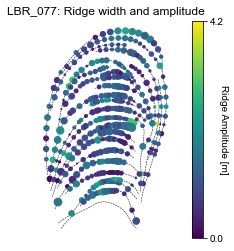

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

itx.plot(ax=ax, column="ridge_amp", markersize="ridge_width", legend=True, missing_kwds={"edgecolor":"k", "facecolor":"None"})
# itx.plot(ax=ax, markersize="ridge_width", facecolor=None)
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
# t.plot(ax=ax, color="k")


cbar = fig.axes[1]
min_max = itx["ridge_amp"].quantile([0,1])
cbar.set_yticks(min_max, labels = np.round(min_max, 1))

cbar.set_ylabel("Ridge Amplitude [m]", rotation=270)

ax.set_title(f"{bend_id}: Ridge width and amplitude")
ax.set_axis_off()
# plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/{bend_id}_HighAmplitude.png", dpi=300)

# Ridge Amplitudes
**Problem**: initial ridge amps are too high  
**Solution**: Force ridge amp calculation to only use inner measurement  

**Code Problem**: RidgeDataExtractor does not know where on the transect it currently is  
**Code Solution**: Introduce transect position to the RDE and Ridge Amp calulations  

In [6]:
s = " False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True True  True  True  True  True  True  True  True  True  True  True  True True  True  True  True  True  True  True  True False False False False True  True  True  True  True  True  True  True"

s.replace(" ", "").replace("e", "e, ")

'False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, '

In [7]:
a = np.array([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True])
a

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [8]:
np.flatnonzero(a)

array([107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 132, 133, 134, 135, 136,
       137, 138, 139])

In [9]:
first_pos = np.flatnonzero(a)[0]


In [10]:
~(a[first_pos:])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False])

What about removing the first null space from the mask makes the ridge centers of mass mismatch?

In [11]:
np.nanmin([np.nan, np.nan])

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_26141/3906233256.py:1: RuntimeWarning: All-NaN axis encountered
  np.nanmin([np.nan, np.nan])


nan

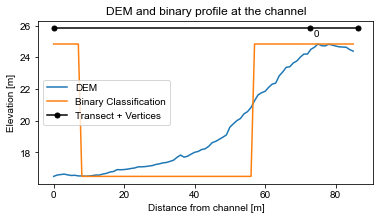

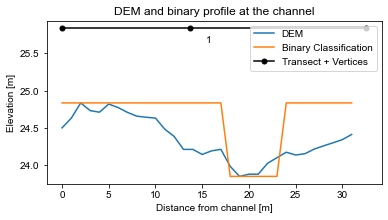

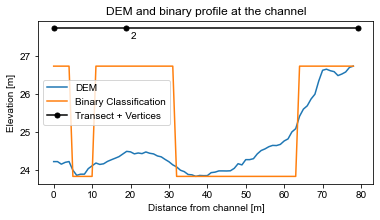

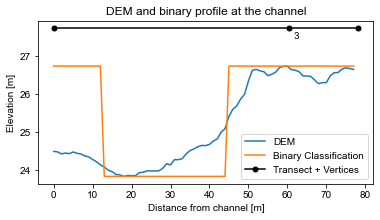

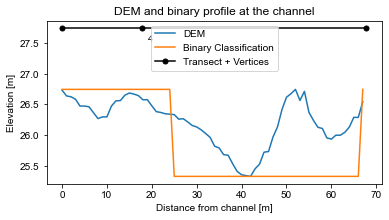

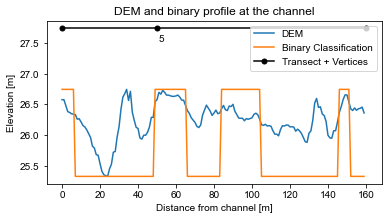

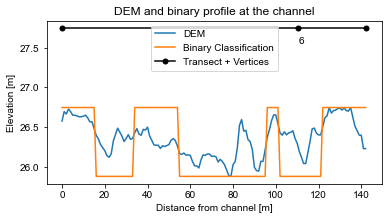

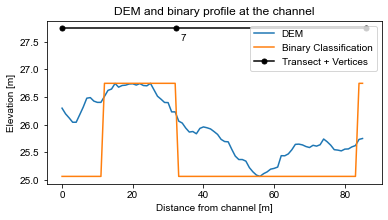

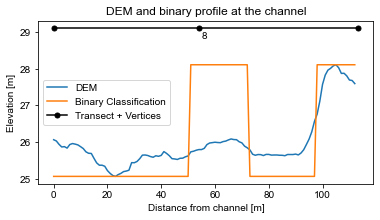

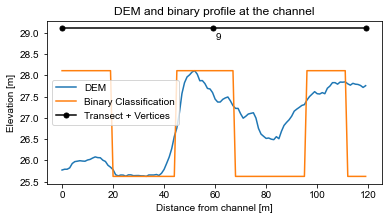

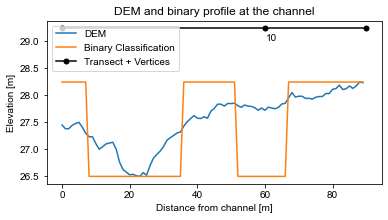

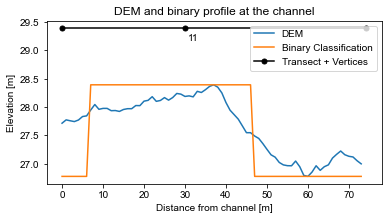

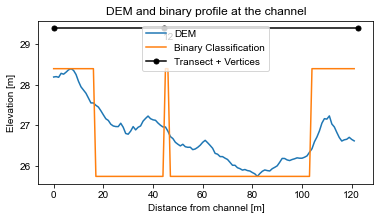

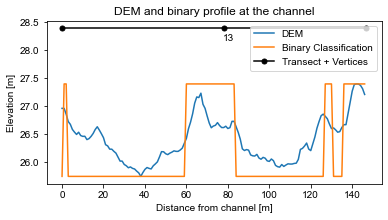

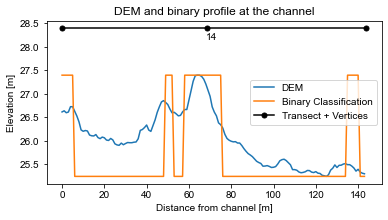

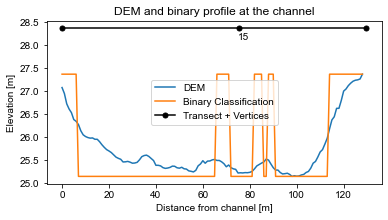

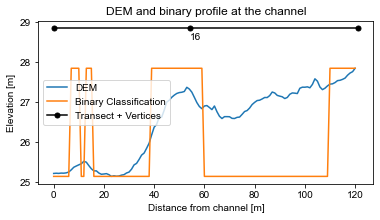

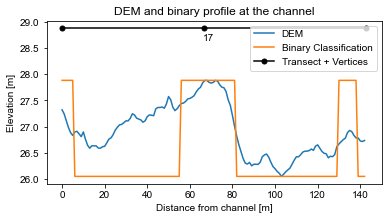

In [15]:
chosen_transect = itx.loc["t_016"].sort_values("transect_position")
for i, row in chosen_transect.iterrows():

    geom = row["substring_geometry"]
    dem_sig = row["dem_signal_selection"]
    # bin_sig = row["bin_signal"]
    bin_sig = row["bool_mask"]
    pos = row["transect_position"]
    dq_adj = row["swale_dq_adjustment"]

    fig, ax = plt.subplots(1,1, figsize=(6, 3))
    ax.plot(dem_sig, label="DEM")
    ax.plot((bin_sig * (np.nanmax(dem_sig)- np.nanmin(dem_sig)))+ np.nanmin(dem_sig), label="Binary Classification")

    p1, p2, p3 = [Point(p) for p in geom.coords]
    d1 = p1.distance(p2) - dq_adj
    d2 = p2.distance(p3)

    x = [0, d1, d1+d2]
    y = np.ones(3)*np.nanmax(dem_sig)+1
    ax.plot(x, 
            y,
            color="k",
            marker=".",
            markersize=10,
            label = "Transect + Vertices")
    
    ax.annotate(pos, (x[1]+2, y[1]-0.1), verticalalignment="top", horizontalalignment="center", )
    ax.legend()
    ax.set_title("DEM and binary profile at the channel")
    ax.set_ylabel("Elevation [m]")
    ax.set_xlabel("Distance from channel [m]")


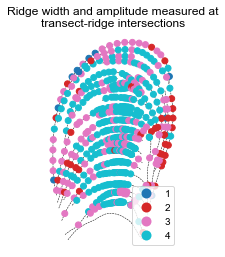

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

itx.plot(ax=ax, categorical=True, column="metric_confidence", legend=True)
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)

# cbar = fig.axes[1]
# min_max = itx["ridge_amp"].quantile([0,1])
# cbar.set_yticks(min_max, labels = np.round(min_max, 1))

cbar.set_ylabel("Ridge Amplitude [m]", rotation=270)

ax.set_title("Ridge width and amplitude measured at\ntransect-ridge intersections")
ax.set_axis_off()
# plt.savefig("/Users/avan/FLUD/BrazosScrolls/figures/WidthAndAmpAtItx_newmethod.png", dpi=300)

<AxesSubplot:xlabel='transect_position'>

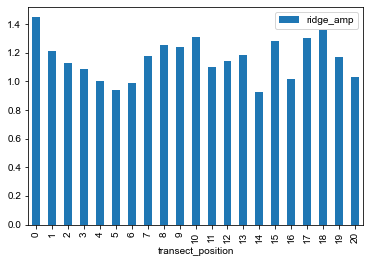

In [14]:
itx.groupby("transect_position")[["ridge_amp"]].mean().plot(kind="bar")

## General Metrics I want to see

1. Variation within packets
2. Variation along transects
3. Variation along ridges
